Text(0.5, 1.0, 'original cover image')

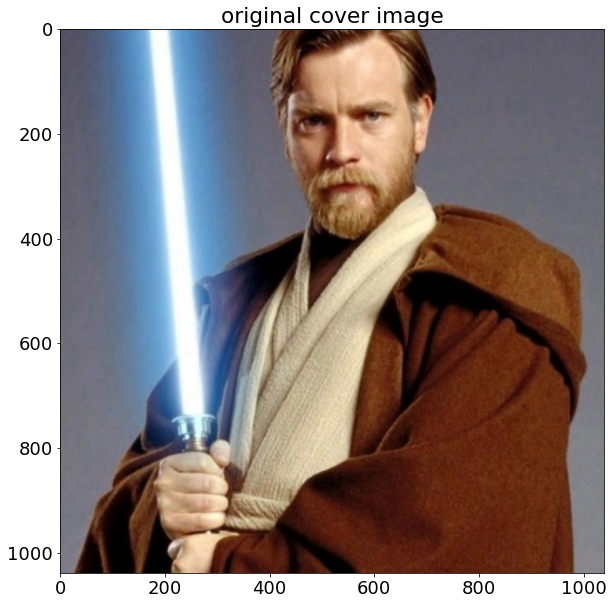

In [1]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
# PATH = "ImageSources\\jfif\\the_rock.jfif"
PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels
cover_cols, cover_rows = image.size

plt.figure()
# plt.subplot(121)
plt.imshow(image)
plt.title("original cover image")

Functions for encoding and decoding

In [2]:
string="""It's about drive, it's about power
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    return [int(i)*gain for i in string_bits]

def text_from_bits_int(bits):
    # convert each element to string
    string_bits = [str(i) for i in bits]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode

gain = 20000
bin_encoded =  text_to_bits_int(string, gain)


print(bin_encoded[:10])
# bin_decoded = text_from_bits_int(bin_encoded)
# print("bin_decoded:", bin_decoded)

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital


[0, 20000, 0, 0, 20000, 0, 0, 20000, 0, 20000]


Embed hidden message inside the absolute spektrum of the Fourier-Transform and reverse the process to save the resulting image as .png

MASK:

cut:  0.09110705107987359
message length: 4392
confirm: 4512.5


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

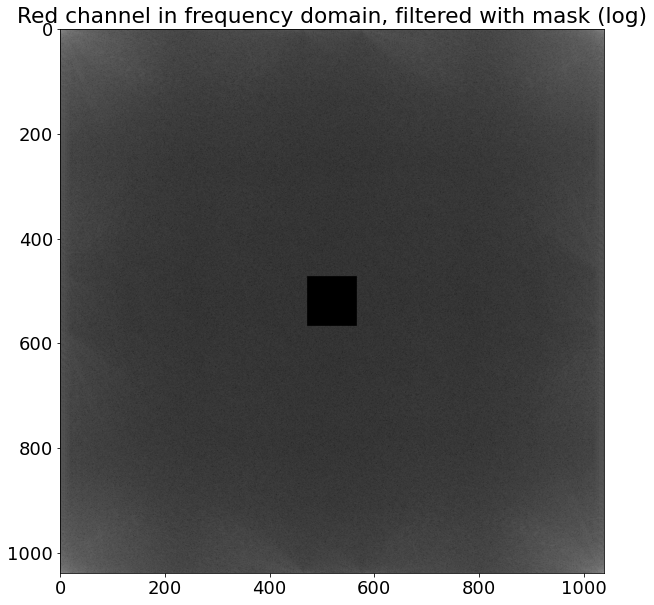

In [14]:
cut=0.1
# calculate minimum part to be cut and add another 1% because of rounding errors and for "safety"
cut = np.sqrt(2*len(bin_encoded)/(cover_cols*cover_rows))*1.01

cover_r_fft=np.fft.fft2(Rot)                            #FFT on R Channel
cover_r_fft_abs = np.abs(cover_r_fft)
cover_r_fft_shift = np.fft.fftshift(cover_r_fft_abs)

# plot red channel absolute fft
# im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
# plt.figure()
# plt.imshow(im)
# plt.title("Red channel in frequency domain (log, shifted)")

#cut off high frequencies from R channel
cover_r_fft_mask = np.full((cover_rows, cover_cols), True)
row_start = round(cover_rows/2*(1-cut))
row_stop = round(cover_rows/2*(1+cut))
col_start = round(cover_cols/2*(1-cut))
col_stop = round(cover_cols/2*(1+cut))
cover_r_fft_mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

# x-length of the mask
x_len_mask = col_stop - col_start 
# y-length of the mask
y_len_mask = row_stop - row_start 

print("cut: ", cut)
print("message length:", len(bin_encoded))
print("confirm:", x_len_mask*y_len_mask/2)


# plt.figure()
# plt.imshow(cover_r_fft_mask, cmap="gray")
# plt.title("sharp mask")


cover_r_fft_masked = cover_r_fft_abs*cover_r_fft_mask
im = Image.fromarray(20*np.log10(cover_r_fft_masked))
plt.figure()
plt.imshow(im)
plt.title("Red channel in frequency domain, filtered with mask (log)")

max value: 255


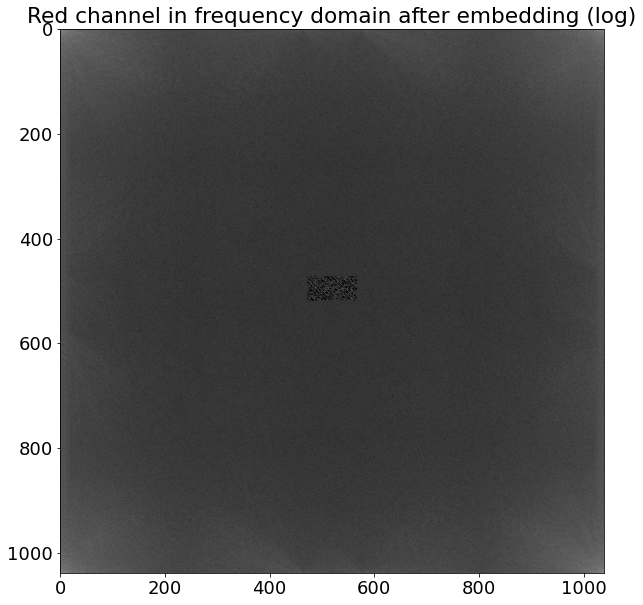

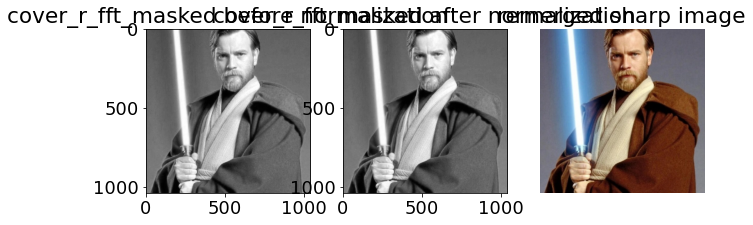

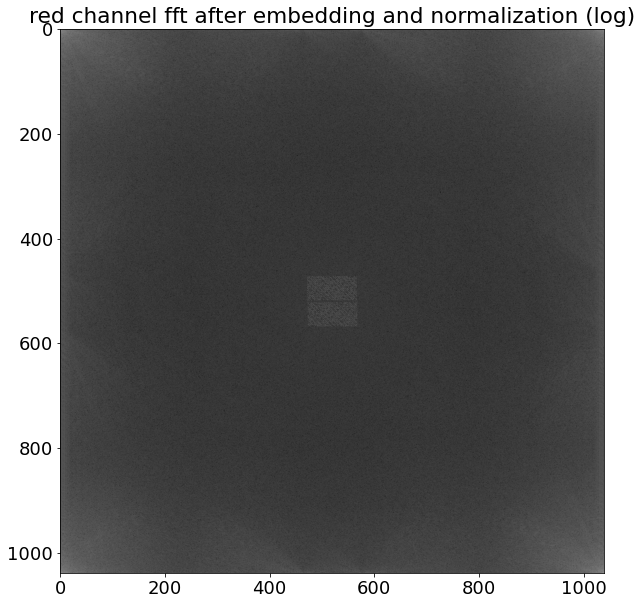

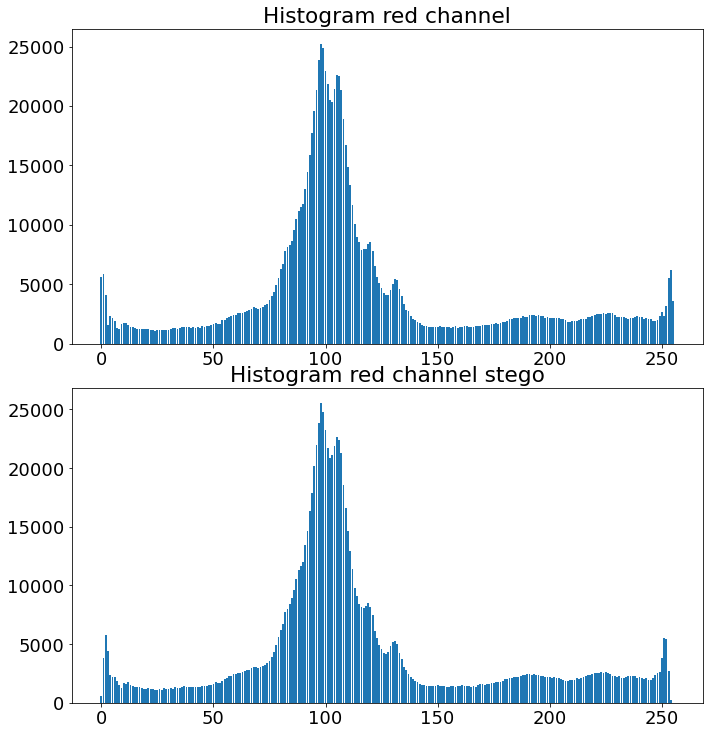

In [15]:
counter=0
# write hidden message into filtered absolute part
for i in range(cover_rows):
    # if cover_rows == 50:
    #     print("max values", np.max(cover_r_fft_abs[i]))
    for j in range(cover_cols):
        # write where coefficients are zero -> previously filtered out.
        if cover_r_fft_mask[i,j]==0:
            if counter<len(bin_encoded):
                # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                cover_r_fft_abs[i,j]=bin_encoded[counter]
                # print(cover_r_fft_abs[i,j])
                counter+=1

# # mirror reverse loop
# counter = 0
# for i in range(cover_rows-1, -1, -1):
#     for j in range(cover_cols-1, -1, -1):
#         if cover_r_fft_mask[i,j]==0:
#             if counter < len(bin_encoded):
#                 cover_r_fft_abs[i,j]=bin_encoded[counter]
#                 counter+=1


# plot absolute after embedding information
im = Image.fromarray(20*np.log10(cover_r_fft_abs))
plt.figure()
plt.imshow(im)
plt.title("Red channel in frequency domain after embedding (log)")
#IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
cover_r_masked = np.fft.ifft2(cover_r_fft_abs*np.exp(1j*np.angle(cover_r_fft))).real
# print(cover_r_masked)


plt.figure()
plt.subplot(131)
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")

cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)
plt.subplot(132)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
print("max value:", np.max(cover_r_masked_norm))
# cover_r_masked_norm = cover_r_masked

# merge layers
stego =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
img = Image.fromarray(stego)     #create image from remerged matrix
# plt.figure()
plt.subplot(133)
plt.axis('off')
plt.imshow(img) #Show picture with embeddes secret message
plt.title("remerged sharp image")


sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fft2(cover_r_masked_norm))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after embedding and normalization (log)")


# show histogram
cover_r_hist = Rot.histogram()
stego_r_hist = img.split()[0].histogram()
plt.figure()
plt.subplot(211)
plt.tight_layout()
plt.bar(np.arange(len(cover_r_hist)), cover_r_hist)
plt.title("Histogram red channel")
plt.subplot(212)
plt.bar(np.arange(len(stego_r_hist)), stego_r_hist)
plt.title("Histogram red channel stego")

im = img.save("ImageSources\\Steganograms\\remerged_sharp", format="png")     #save image as png

max value stego_r:
 255
[  606 10058   459   291  9977  1109   446 10341  1153  9462  9809 10892
   166 10035   445   727   722   655 10360   590]
[ 1100  9871  9185 10602   552   684  9496   129   855 10869 10672   499
 10914   890   150 10142   926  9586 10459 11025]
message sum [ 1706 19929  9644 ...  1090  9621   858]
threshold 5855.5
bin_decoded: It's about drive, it's about power
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana



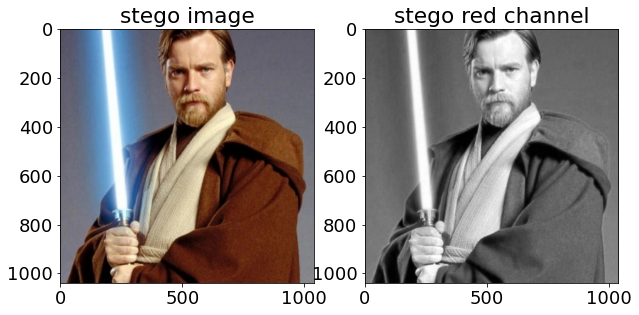

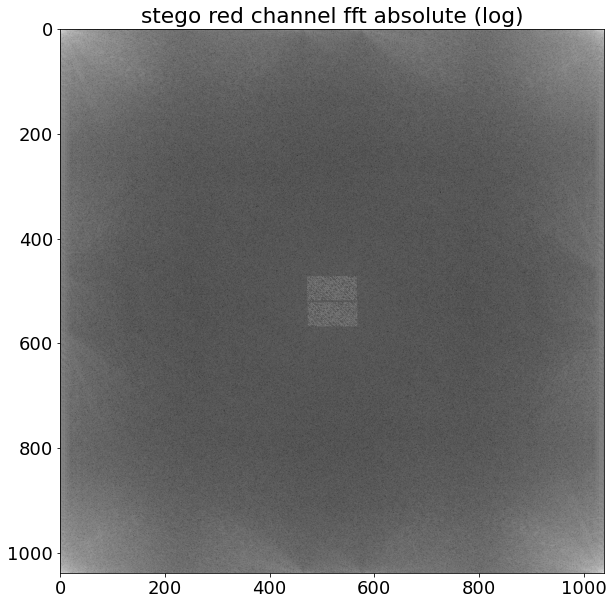

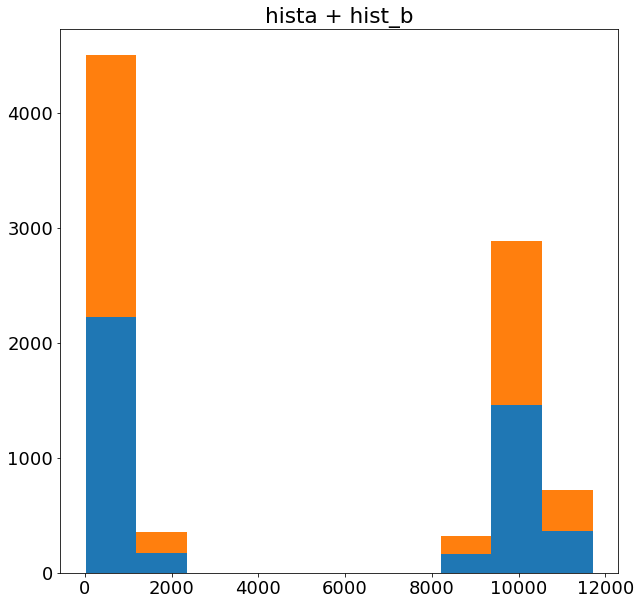

In [16]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp", formats=["png"])
plt.figure()
plt.subplot(121)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

plt.subplot(122)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

print("max value stego_r:\n", np.max(stego_r))

# transform R channel into frequency domain
stego_r_fft =np.fft.fft2(stego_r)
stego_r_fft_abs = np.abs(stego_r_fft)
# stego_r_fft_abs_shift = np.fft.fftshift(stego_r_fft_abs)

plt.figure()
# plt.subplot(121)
plt.imshow(20*np.log10(stego_r_fft_abs), cmap="gray")
plt.title("stego red channel fft absolute (log)")

# calculate mask
stego_r_fft_mask = np.full((cover_rows, cover_cols), True)
row_start = round(cover_rows/2*(1-cut))
row_stop = round(cover_rows/2*(1+cut))
col_start = round(cover_cols/2*(1-cut))
col_stop = round(cover_cols/2*(1+cut))
stego_r_fft_mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

# show mask
# plt.figure()
# plt.imshow(20*np.log10(stego_r_fft_mask*stego_r_fft_abs), cmap="gray")
# plt.title("masked fft")


message_a=np.zeros(len(bin_encoded), dtype='uint32')
counter=0
for i in range(cover_rows):
    for j in range(cover_cols):
        if stego_r_fft_mask[i,j]==0:
            if counter==len(bin_encoded):
                break
            message_a[counter] = stego_r_fft_abs[i,j]
            counter+=1 

message_b=np.zeros(len(bin_encoded), dtype='uint16')
counter=0
for i in range(cover_rows-1, -1, -1):
    for j in range(cover_cols-1, -1, -1):
        if stego_r_fft_mask[i,j]==0:
            if counter==len(bin_encoded):
                break
            message_b[counter] = stego_r_fft_abs[i,j]
            counter+=1 


print(message_a[:20])
print(message_b[:20])

plt.figure()
plt.hist((message_a, message_b), histtype="barstacked")
plt.title("hista + hist_b")
# plt.figure()
# plt.hist(message_a, histtype="bar")
# plt.title("hist_a")

message = np.add(message_a, message_b)
print("message sum", message)
message = message_a
# print(message[:20])

threshold = np.max(message)/2
print("threshold", threshold)
binary = message2bin(message, threshold)
Text = text_from_bits_int(binary)
print("bin_decoded:", Text)

values[@gain 10000]: 

[ 3223  8218  3030  3135  6473   786  5489 12004  4162 10121  8763  7788
  4681  6328  3283  3874  4329  7522 10771  1024]


values[@gain 10000 double]: 

[ 3167  7655  3073  3203  6240   681  5123 11940  3837  9893  8536  7680
  4868  6071  3432  3621  4226  7251 10733   819]

values[@gain 10000 single short]:

[ 3655  6828  2801  3899  5343  2095  7052 10688  4120 10260  8741  7496
  6164  6266  3174  4293  3294  7546 10320  1888]